
# Machine Translation 



## Introduction
In this notebook, I will build a deep neural network that functions as part of an end-to-end machine translation pipeline. My completed pipeline will accept English text as input and return the Persian translation.


- **Dataset** - To laod and investigate dataset
- **Preprocess** - To convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations.

- **Prediction** Run the model on English text.

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.ticker as ticker
import re
import os
import io
import time
import collections
import tensorflow as tf
import unicodedata
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, LSTM, Flatten
from tensorflow.keras.layers import Embedding, RepeatVector, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split

%matplotlib inline

### Verify access to the GPU

The following test applies only if you expect to be using a GPU and verify that the device_type is "GPU".


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11720315345421004392,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5431029085691602460
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7092450112
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11175662991275045979
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8836071686770997679
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
tf.__version__
#opus.nlpl.eu/download.php?f=TEP/v1/moses/en-fa.txt.zip

'2.2.0'

## 1. Dataset
I begin by laoding and investigating the dataset that will be used to train and evaluate my pipeline.  The dataset, used for machine translation are from [manythings](http://www.manythings.org/anki/).  However, that will take a long time to train a neural network on.  I'll be using a dataset, created for this project that contains a small vocabulary.  

### Load Data

The data is located in `data/pes.txt` . The `pes.txt` file contains English sentences with their Persian translations. Load the English and Persian data from the files from running the cell below. 


* Each line in the file contains an English sentence with the respective translation in each line.


In [4]:
data_path_source = "./data/en-fa/TEP.en-fa.en"#Read the data
data_path_target = "./data/en-fa/TEP.en-fa.fa"#Read the data

source_lines_raw= pd.read_table(data_path_source,names=['source'],  )
source_lines_raw.index.name= "ID"

target_lines_raw= pd.read_table(data_path_target,names=['target'])
target_lines_raw.index.name= "ID"

traget_source_join = pd.merge(source_lines_raw, target_lines_raw, on="ID")

In [5]:
traget_source_join#.iloc[457].values[1]

,source,target
ID,,
0,raspy breathing .,صداي خر خر .
1,dad .,پدر .
2,maybe its the wind .,شايد صداي باد باشه .
3,no .,نه .
4,stop please stop .,دست نگه داريد خواهش ميکنم دست نگه داريد .
...,...,...
611899,zodiac .,بيگانه پرست .
611900,zodiacal light .,اجنبي پرست .
611901,zombi .,دشمن بيگانه .


## 2. Preprocess

For this project, I won't use text data as input to your model. Instead, I'll convert the text into sequences of integers using the following preprocess methods:

1. Convert word into lowercase
2. Clean sentences and Remove punctuaions 
3. Adding 'start_ ' and  ' _end' at the start and end of the sentences 
4. Tokenize the words into ids
5. Add padding to make all the sequences the same length.

Time to start preprocessing the data...


In [6]:
def preprocessing_sentence(sentence):  
    
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    sentence=  'start ' + sentence + ' end'
    
    return sentence

In [7]:
def create_dataset(data_frame):
    
    source = data_frame["source"].map(preprocessing_sentence).values
    target = data_frame["target"].map(preprocessing_sentence).values

    return source, target


In [37]:
sample_traget_source_join = traget_source_join.sample(traget_source_join.shape[0]//25)
source, target = create_dataset(sample_traget_source_join)

In [38]:
print("Number of sentences of the source: {} ".format(len(source)))
print("Number of sentences of the target: {} ".format(len(target)))

Number of sentences of the source: 24476 
Number of sentences of the target: 24476 


In [39]:
source

array(['start into the banquet  ,  the monkey king crashed uninvited  . end',
       'start of their none too numerous years  . end',
       'start if i tell you about them ,  you have no idea what hell do . end',
       ..., 'start the new governor has arrived . end',
       'start madam ! end', 'start why was i lied before sorry  . end'],
      dtype=object)

In [40]:
target

array(['start پادشاه ميمون ناخوانده وارد مهماني شد  . end',
       'start دوره\u200cي خود را ديده بودند  . end',
       'start نتونستيد بالونم رو پيدا كنيد ؟ آره  .  پيداش كرديم end',
       ..., 'start خفه شو ! end',
       'start یانگوم درباره این موضوع نباید صحبتی بکند end',
       'start چرا قبلا دروغ گفتيد متاسفم  . end'], dtype=object)

### Tokenize 

For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity.

I turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. I use this function to tokenize `english_sentences` and `persian_sentences` in the cell below.


### Padding 

When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding **to the end** of the sequences to make them the same length.

To make sure all the English sequences have the same length and all the Persian sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.


In [41]:
# create a tokenizer for source sentence

source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters = " ")# Fit the source sentences to the source tokenizer
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)

#Sequences that are shorter, padded with 0 at the end.
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [42]:
source_tensor.shape

(24476, 29)

In [43]:
# create the target sentence tokenizer

target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters = " ")# Fit the tokenizer on target sentences
target_sentence_tokenizer.fit_on_texts(target)#conver target text to sequnec of integers
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)# Post pad the shorter sequences with 0

target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post', maxlen=source_tensor.shape[1], )

In [44]:
target_tensor.shape

(24476, 29)

In [45]:
# Reshaping the source and target to work with a basic GRU

source_tensor = source_tensor.reshape((-1, source_tensor.shape[1], 1))
target_tensor = target_tensor.reshape((-1, target_tensor.shape[1], 1))

In [46]:
print("The shape of the source: {} ".format(source_tensor.shape))
print("The shape of the target: {} ".format(target_tensor.shape))


The shape of the source: (24476, 29, 1) 
The shape of the target: (24476, 29, 1) 


In [47]:
def to_text(source, tokenizer):
    """
    Turn sequence from a Ids into text using the tokenizer
    :param source: sequence aof IDs
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the IDs
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[s] for s in source])


In [48]:
random_id =  np.random.randint(0, high=source_tensor.shape[0])
for i in range(random_id,random_id+1):
    print("---------------------------------------------------------------------------------------------------")
    print('Sequence number is {} '.format(i + 1))
    print()
    print(' English Input:  {}'.format(to_text(source_tensor[i,:,0], source_sentence_tokenizer)))
    print()
    print(' Persian Output: {}'.format(to_text(target_tensor[i,:,0], target_sentence_tokenizer)))


---------------------------------------------------------------------------------------------------
Sequence number is 6406 

 English Input:  start australem means south . and then . . . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

 Persian Output: start گفته که اونجا آدمي زندگي مي کنه end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


### Split into Train and Test

Split the dataset into a test and train. 80% of data is used for training and 20% for testing the model


In [49]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [50]:
#That + 1 is because of reserving padding ( index zero)
source_vocab_size= len(source_sentence_tokenizer.word_index)+1
target_vocab_size= len(target_sentence_tokenizer.word_index)+1

In [51]:
print("Size of the source vocabulary: {}".format(source_vocab_size))
print("Size of the target vocabulary: {}".format(target_vocab_size))

Size of the source vocabulary: 14209
Size of the target vocabulary: 20950


In [52]:
print("The shape of the source train tensor: {} ".format(source_train_tensor.shape))
print("The shape of the target train tensor: {} ".format(target_train_tensor.shape))


The shape of the source train tensor: (19580, 29, 1) 
The shape of the target train tensor: (19580, 29, 1) 


In [53]:
print("The shape of the source test tensor: {} ".format(source_test_tensor.shape))
print("The shape of the target test tensor: {} ".format(target_test_tensor.shape))

The shape of the source test tensor: (4896, 29, 1) 
The shape of the target test tensor: (4896, 29, 1) 


## 3. Models
In this section, I will experiment with various neural network architectures.
I will begin by training four relatively simple architectures.
- Model 1 is a simple GRU
- Model 2 is a GRU with Embedding
- Model 3 is a Bidirectional GRU
- Model 4 is an Encoder-Decoder GRU

After experimenting with the four simple architectures, I will construct a deeper architecture that is designed to outperform all four models which uses Attention mechanism.


### Model 1: GRU
![RNN](./images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a GRU that translates English to Persian.

In [54]:
def simple_model(input_shape, english_vocab_size, persian_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    #Build the layers
    learning_rate = 0.009    
    
    inputs = Input(shape=(input_shape[1:]))
    gru = GRU(1024, input_shape=inputs.shape[1:], return_sequences=True)(inputs)
    logits = TimeDistributed(Dense(persian_vocab_size, activation="softmax"))(gru)
    
    model = Model(inputs, logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model



In [55]:

# Train the neural network
simple_model = simple_model(source_train_tensor.shape,
                            source_vocab_size,
                            target_vocab_size)
simple_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 29, 1024)          3154944   
_________________________________________________________________
time_distributed (TimeDistri (None, 29, 20950)         21473750  
Total params: 24,628,694
Trainable params: 24,628,694
Non-trainable params: 0
_________________________________________________________________


In [56]:
simple_model.fit(source_train_tensor,target_train_tensor, batch_size=128, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
123/123 - 37s - loss: 2.5168 - accuracy: 0.7088 - val_loss: 2.2047 - val_accuracy: 0.7201
Epoch 2/10
123/123 - 18s - loss: 2.1030 - accuracy: 0.7212 - val_loss: 2.1408 - val_accuracy: 0.7225
Epoch 3/10
123/123 - 17s - loss: 2.0201 - accuracy: 0.7227 - val_loss: 2.1453 - val_accuracy: 0.7228
Epoch 4/10
123/123 - 17s - loss: 1.9697 - accuracy: 0.7232 - val_loss: 2.1555 - val_accuracy: 0.7221
Epoch 5/10
123/123 - 17s - loss: 1.9229 - accuracy: 0.7236 - val_loss: 2.1556 - val_accuracy: 0.7233
Epoch 6/10
123/123 - 17s - loss: 1.8769 - accuracy: 0.7240 - val_loss: 2.1727 - val_accuracy: 0.7233
Epoch 7/10
123/123 - 17s - loss: 1.8316 - accuracy: 0.7241 - val_loss: 2.1884 - val_accuracy: 0.7236
Epoch 8/10
123/123 - 17s - loss: 1.7871 - accuracy: 0.7241 - val_loss: 2.2072 - val_accuracy: 0.7233
Epoch 9/10
123/123 - 17s - loss: 1.7454 - accuracy: 0.7243 - val_loss: 2.2364 - val_accuracy: 0.7222
Epoch 10/10
123/123 - 17s - loss: 1.7039 - accuracy: 0.7249 - val_loss: 2.2397 - val_accura

### Evaluate Model on test Dataset

In [57]:
simple_model.evaluate(source_test_tensor,target_test_tensor, batch_size=256)

20/20 [==============================] - 2s 96ms/step - loss: 2.2359 - accuracy: 0.7234


[2.235947370529175, 0.7234406471252441]


### Ids Back to Text

The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the Persian translation. 

In [58]:
def logits_to_text(logits,ground_true, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    
    prediction = ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
    ground_true = ' '.join([index_to_words[t[0]]  for t in ground_true[0]])

    print()
    print("The prediction is:\n\n {}".format(prediction))
    print()
    print("The prediction should be:\n\n {}".format(ground_true))



### Make Prediction using the trained Model

In [60]:
print ("prediction(s)...")
print()

random_id =  np.random.randint(0, high=source_test_tensor.shape[0])
test = source_test_tensor[random_id:random_id+1]
ground_truth = target_test_tensor[random_id:random_id+1]


print("The input sequence is:\n\n {}".format(to_text(test[0,:,0], source_sentence_tokenizer)))

print(logits_to_text(simple_model.predict(test)[0], ground_truth ,target_sentence_tokenizer))



prediction(s)...

The input sequence is:

 start i got him . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction is:

 start من به . . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction should be:

 start من اونو ميارم . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


### Model 2: Embedding 
![RNN](./images/embedding.png)
I've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a GRU model using embedding.

In [62]:
def embed_model(input_shape, english_vocab_size, persian_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate =  0.009    
    inputs = Input(input_shape[1:])
    embedding = Embedding(english_vocab_size, 256)(inputs)
    gru = GRU(1024, return_sequences=True)(embedding)
    logits = TimeDistributed(Dense(persian_vocab_size, activation="softmax"))(gru)
    
    model = Model(inputs, logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

# Reshaping the input to work with the model
reshaped_source_train_tensor = source_train_tensor.reshape((-1, source_train_tensor.shape[-2]))


# Train the neural network
embedding_model = embed_model(reshaped_source_train_tensor.shape,
                              source_vocab_size,
                              target_vocab_size)
embedding_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 29, 256)           3637504   
_________________________________________________________________
gru_1 (GRU)                  (None, 29, 1024)          3938304   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 29, 20950)         21473750  
Total params: 29,049,558
Trainable params: 29,049,558
Non-trainable params: 0
_________________________________________________________________


In [63]:
embedding_model.fit(reshaped_source_train_tensor, target_train_tensor, batch_size=128, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
123/123 - 20s - loss: 2.2957 - accuracy: 0.7147 - val_loss: 2.0568 - val_accuracy: 0.7262
Epoch 2/10
123/123 - 20s - loss: 2.8797 - accuracy: 0.7121 - val_loss: 3.4447 - val_accuracy: 0.7194
Epoch 3/10
123/123 - 20s - loss: 3.4138 - accuracy: 0.7244 - val_loss: 3.4570 - val_accuracy: 0.7035
Epoch 4/10
123/123 - 20s - loss: 3.3872 - accuracy: 0.7271 - val_loss: 3.4183 - val_accuracy: 0.7159
Epoch 5/10
123/123 - 20s - loss: 3.3650 - accuracy: 0.7320 - val_loss: 3.4228 - val_accuracy: 0.7155
Epoch 6/10
123/123 - 20s - loss: 3.3602 - accuracy: 0.7334 - val_loss: 3.4164 - val_accuracy: 0.7231
Epoch 7/10
123/123 - 20s - loss: 3.3495 - accuracy: 0.7362 - val_loss: 3.4206 - val_accuracy: 0.7163
Epoch 8/10
123/123 - 20s - loss: 3.3509 - accuracy: 0.7364 - val_loss: 3.4309 - val_accuracy: 0.7150
Epoch 9/10
123/123 - 20s - loss: 3.3435 - accuracy: 0.7381 - val_loss: 3.4297 - val_accuracy: 0.7230
Epoch 10/10
123/123 - 20s - loss: 3.3339 - accuracy: 0.7402 - val_loss: 3.4240 - val_accura

### Evaluate Model on test Dataset

In [64]:
# Reshaping the input to work with the model
reshaped_source_test_tensor = source_test_tensor.reshape((-1, source_test_tensor.shape[-2]))

embedding_model.evaluate(reshaped_source_test_tensor, target_test_tensor, batch_size=256)

20/20 [==============================] - 2s 97ms/step - loss: 3.4266 - accuracy: 0.7213


[3.426565170288086, 0.7212995886802673]

### Make Prediction using the trained Model

In [65]:
print ("prediction(s)...")
print()

random_id =  np.random.randint(0, high=source_test_tensor.shape[0])

test = source_test_tensor[random_id:random_id+1]
ground_truth = target_test_tensor[random_id:random_id+1]


print("The input sequence is:\n\n {}".format(to_text(test[0,:,0], source_sentence_tokenizer)))

print(logits_to_text(embedding_model.predict(test)[0],ground_truth ,target_sentence_tokenizer))



prediction(s)...

The input sequence is:

 start its related to the captains story . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction is:

 start اين در . در end . end end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction should be:

 start اما به خاطر شكستي كه خوردند الان در موقعيت بدي هستند end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


### Model 3: Bidirectional GRus
![RNN](./images/bidirectional.png)

One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [67]:
def bd_model(input_shape, english_vocab_size, persian_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate =  0.009
    
    inputs = Input(shape=input_shape[1:])
    embedding = Embedding(english_vocab_size, 256)(inputs)
    bidirectional = Bidirectional(GRU(1024, return_sequences=True))(embedding)
    logits = TimeDistributed(Dense(persian_vocab_size, activation="softmax"))(bidirectional)
    
    model = Model(inputs, logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

    
#tests.test_bd_model(bd_model)

In [68]:
# Train the neural network
bidirectioanl_model = bd_model(reshaped_source_train_tensor.shape,
                              source_vocab_size,
                              target_vocab_size)
bidirectioanl_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 29, 256)           3637504   
_________________________________________________________________
bidirectional (Bidirectional (None, 29, 2048)          7876608   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 29, 20950)         42926550  
Total params: 54,440,662
Trainable params: 54,440,662
Non-trainable params: 0
_________________________________________________________________


In [69]:
bidirectioanl_model.fit(reshaped_source_train_tensor, target_train_tensor, batch_size=128, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
123/123 - 42s - loss: 4.7380 - accuracy: 0.6957 - val_loss: 4.6009 - val_accuracy: 0.7146
Epoch 2/10
123/123 - 41s - loss: 4.6096 - accuracy: 0.7140 - val_loss: 4.5997 - val_accuracy: 0.7146
Epoch 3/10
123/123 - 41s - loss: 4.6095 - accuracy: 0.7141 - val_loss: 4.5999 - val_accuracy: 0.7146
Epoch 4/10
123/123 - 41s - loss: 4.6099 - accuracy: 0.7140 - val_loss: 4.6002 - val_accuracy: 0.7147
Epoch 5/10
123/123 - 41s - loss: 4.6098 - accuracy: 0.7140 - val_loss: 4.5999 - val_accuracy: 0.7146
Epoch 6/10
123/123 - 41s - loss: 4.6092 - accuracy: 0.7141 - val_loss: 4.5995 - val_accuracy: 0.7147
Epoch 7/10
123/123 - 41s - loss: 4.6096 - accuracy: 0.7140 - val_loss: 4.5999 - val_accuracy: 0.7147
Epoch 8/10
123/123 - 41s - loss: 4.6093 - accuracy: 0.7141 - val_loss: 4.5996 - val_accuracy: 0.7147
Epoch 9/10
123/123 - 41s - loss: 4.6092 - accuracy: 0.7141 - val_loss: 4.5995 - val_accuracy: 0.7147
Epoch 10/10
123/123 - 41s - loss: 4.6095 - accuracy: 0.7141 - val_loss: 4.6008 - val_accura

### Evaluate Model on test Dataset

In [70]:
bidirectioanl_model.evaluate(reshaped_source_test_tensor, target_test_tensor, batch_size=256)

20/20 [==============================] - 3s 140ms/step - loss: 4.6137 - accuracy: 0.7139


[4.613731861114502, 0.7138691544532776]

### Make Prediction using the trained Model

In [75]:
print ("prediction(s)...")
print()

random_id =  np.random.randint(0, high=source_test_tensor.shape[0])

test = source_test_tensor[random_id:random_id+1]
ground_truth = target_test_tensor[random_id:random_id+1]


print("The input sequence is:\n\n {}".format(to_text(test[0,:,0], source_sentence_tokenizer)))

print(logits_to_text(bidirectioanl_model.predict(test)[0],ground_truth ,target_sentence_tokenizer))


prediction(s)...

The input sequence is:

 start theres something i want to say . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction is:

 start بله <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction should be:

 start يه چيزي ميخواستم بگم . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


### Model 4: Encoder-Decoder

Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.



In [77]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, persian_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate =  0.008
    
    inputs = Input(shape=input_shape[1:])
    embedding = Embedding(english_vocab_size, 128)(inputs)
    
    enocder = Bidirectional(GRU(128, return_sequences=True))(embedding)


    #flatt = Flatten()(enocder)
    #repeated_vector  = RepeatVector(output_sequence_length)(flatt)
    
    decoder =  GRU(512, return_sequences=True)(enocder)
    decoder = TimeDistributed(Dense(persian_vocab_size, activation="softmax"))(decoder)

    
    
    model = Model(inputs, decoder)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_encdec_model(encdec_model)


In [78]:
# Train the neural network
encoder_decoder_model = encdec_model(reshaped_source_train_tensor.shape,
                                     reshaped_source_train_tensor.shape[1],
                                      source_vocab_size,
                                      target_vocab_size)
encoder_decoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 29, 128)           1818752   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 29, 256)           198144    
_________________________________________________________________
gru_4 (GRU)                  (None, 29, 512)           1182720   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 29, 20950)         10747350  
Total params: 13,946,966
Trainable params: 13,946,966
Non-trainable params: 0
_________________________________________________________________


In [79]:
encoder_decoder_model.fit(reshaped_source_train_tensor, target_train_tensor, batch_size=64, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
245/245 - 21s - loss: 2.6925 - accuracy: 0.7159 - val_loss: 2.5795 - val_accuracy: 0.7220
Epoch 2/10
245/245 - 20s - loss: 2.2282 - accuracy: 0.7244 - val_loss: 2.1437 - val_accuracy: 0.7184
Epoch 3/10
245/245 - 20s - loss: 2.0050 - accuracy: 0.7312 - val_loss: 2.1387 - val_accuracy: 0.7250
Epoch 4/10
245/245 - 20s - loss: 1.9216 - accuracy: 0.7371 - val_loss: 2.1404 - val_accuracy: 0.7264
Epoch 5/10
245/245 - 20s - loss: 1.8445 - accuracy: 0.7420 - val_loss: 2.1640 - val_accuracy: 0.7232
Epoch 6/10
245/245 - 20s - loss: 1.7475 - accuracy: 0.7462 - val_loss: 2.1875 - val_accuracy: 0.7160
Epoch 7/10
245/245 - 20s - loss: 1.6709 - accuracy: 0.7489 - val_loss: 2.2398 - val_accuracy: 0.7177
Epoch 8/10
245/245 - 20s - loss: 1.5898 - accuracy: 0.7522 - val_loss: 2.2723 - val_accuracy: 0.7180
Epoch 9/10
245/245 - 20s - loss: 1.5177 - accuracy: 0.7550 - val_loss: 2.3014 - val_accuracy: 0.7196
Epoch 10/10
245/245 - 20s - loss: 1.4283 - accuracy: 0.7601 - val_loss: 2.3397 - val_accura

### Evaluate Model on test Dataset

In [80]:
encoder_decoder_model.evaluate(reshaped_source_test_tensor, target_test_tensor, batch_size=50)

98/98 [==============================] - 3s 35ms/step - loss: 2.3317 - accuracy: 0.7162


[2.331676483154297, 0.7161651849746704]

### Make Prediction using the trained Model

In [83]:
print ("prediction(s)...")
print()

random_id =  np.random.randint(0, high=source_test_tensor.shape[0])

test = source_test_tensor[random_id:random_id+1]
ground_truth = target_test_tensor[random_id:random_id+1]


print("The input sequence is:\n\n {}".format(to_text(test[0,:,0], source_sentence_tokenizer)))

print(logits_to_text(encoder_decoder_model.predict(test)[0],ground_truth ,target_sentence_tokenizer))


prediction(s)...

The input sequence is:

 start hi , mr . fleming . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction is:

 start سلام ، ريک ، . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

The prediction should be:

 start سلام آقاى فلمينگ . end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


### Model 4: Encoder Decoder with Attention mechanism 

![Attention](./images/attention.jpg)

In [85]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size= batch_size
        self.encoder_units=encoder_units
        self.embedding=tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru= tf.keras.layers.GRU(encoder_units, 
                                      return_sequences=True,
                                      return_state=True,                                      
                                      recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        #pass the input x to the embedding layer
        x= self.embedding(x)
        # pass the embedding and the hidden state to GRU
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [86]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [87]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        # hidden state shape == (batch_size, hidden size)
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [88]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [89]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        # enc_output (batch_size, max?_lenght, encoder_units) ,enc_hidden (batch_size, encoder_units)
        enc_output, enc_hidden = encoder(inp, enc_hidden) 

        dec_hidden = enc_hidden

        # dec_input(batch_size, 1)
        dec_input = tf.expand_dims( [target_sentence_tokenizer.word_index['start']] * BATCH_SIZE, 1) 

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            
            loss += loss_function(targ[:, t], predictions)

             # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [94]:
target_train_tensor.shape[1]

29

In [97]:
reshaped_source_train_tensor.shape

(19580, 29)

In [98]:
rehsaped_target_train_tensor = target_train_tensor.reshape((-1, target_train_tensor.shape[1]))


#setting the BATCH SIZE
BATCH_SIZE = 64
embedding_dim = 256
units = 1024


#Create data in memeory 
dataset=tf.data.Dataset.from_tensor_slices((reshaped_source_train_tensor, rehsaped_target_train_tensor)).shuffle(BATCH_SIZE)# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [99]:
encoder = Encoder(source_vocab_size, embedding_dim=embedding_dim ,  encoder_units=units,  batch_size =BATCH_SIZE)

In [100]:
decoder= Decoder(vocab_size= target_vocab_size , embedding_dim=embedding_dim, dec_units=units, batch_sz =BATCH_SIZE)

In [101]:
checkpoint_dir = './encode_dcoder_attention_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [242]:
EPOCHS = 10
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)


    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 0.1586
Epoch 1 Batch 100 Loss 0.1238
Epoch 1 Batch 200 Loss 0.1984
Epoch 1 Batch 300 Loss 0.1195
Epoch 1 Loss 0.1397
Time taken for 1 epoch 56.792092084884644 sec

Epoch 2 Batch 0 Loss 0.1470
Epoch 2 Batch 100 Loss 0.1209
Epoch 2 Batch 200 Loss 0.1618
Epoch 2 Batch 300 Loss 0.1199
Epoch 2 Loss 0.1294
Time taken for 1 epoch 57.468533992767334 sec

Epoch 3 Batch 0 Loss 0.1318
Epoch 3 Batch 100 Loss 0.0990
Epoch 3 Batch 200 Loss 0.1717
Epoch 3 Batch 300 Loss 0.0947
Epoch 3 Loss 0.1250
Time taken for 1 epoch 57.067235231399536 sec

Epoch 4 Batch 0 Loss 0.1428
Epoch 4 Batch 100 Loss 0.1102
Epoch 4 Batch 200 Loss 0.1071
Epoch 4 Batch 300 Loss 0.0920
Epoch 4 Loss 0.1197
Time taken for 1 epoch 57.55889272689819 sec

Epoch 5 Batch 0 Loss 0.1231
Epoch 5 Batch 100 Loss 0.1107
Epoch 5 Batch 200 Loss 0.1051
Epoch 5 Batch 300 Loss 0.1047
Epoch 5 Loss 0.1077
Time taken for 1 epoch 58.72194170951843 sec

Epoch 6 Batch 0 Loss 0.0898
Epoch 6 Batch 100 Loss 0.1026
Epoch 6 Batch 200 L

### Make Prediction using the trained Model

In [243]:

def evaluate(sentences, source_sentence_tokenizer = source_sentence_tokenizer, target_sentence_tokenizer = target_sentence_tokenizer):
    
    
    max_length =  source_train_tensor.shape[1]
    attention_plot = np.zeros((max_length, max_length))

    

    sentence = preprocessing_sentence(sentences)
    inputs = [source_sentence_tokenizer.word_index[w] for w in sentences.split(" ")]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen =  max_length, padding = "post")
    
    inputs = tf.convert_to_tensor(inputs)
    result = " "
    
    hidden =  [tf.zeros((1, units))]
    
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden =  enc_hidden
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start']], 0)
    
    for t in range(max_length):
        
        predictions, dec_hidden, attention_weights  =  decoder(dec_input, dec_hidden, enc_out)

        #storing the attention weights to plot later on

        attention_weights =  tf.reshape(attention_weights,(-1, ))
        attention_plot [t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        
        
        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        if target_sentence_tokenizer.index_word[predicted_id] == 'end':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot   
    
    
    

In [244]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize= (10,10) )
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap = "viridis")
    
    fontdict = {"fontsize":14}
    ax.set_xticklabels([" "]+sentence, fontdict= fontdict, rotation= 90, )
    ax.set_yticklabels([" "]+predicted_sentence, fontdict= fontdict,)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [245]:
def translate(sentence):
    
    result, sentence, attention_plot  = evaluate(sentence)
    
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    

In [256]:
random_id =  np.random.randint(0, high=source_test_tensor.shape[0])

sentence = []
for i in source_test_tensor[random_id,:,:]:
    if i[0]== 0:
        break
    sentence.append(source_sentence_tokenizer.index_word[i[0]])
sentence = ' '.join(sentence[1:-1])

In [257]:
print("Sentence is: ",sentence)
print('Persian Ground Truth is::  {}'.format(to_text(target_test_tensor[random_id,:,0], target_sentence_tokenizer)))


Sentence is:  how can i understand your predicament . . .
Persian Ground Truth is::  start چیزی شده؟ end <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Input: start how can i understand your predicament  .   .   . end
Predicted translation:  اين معجزه ، بازي نيست . end 


/home/rima/anaconda3/envs/ESFP/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/rima/anaconda3/envs/ESFP/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


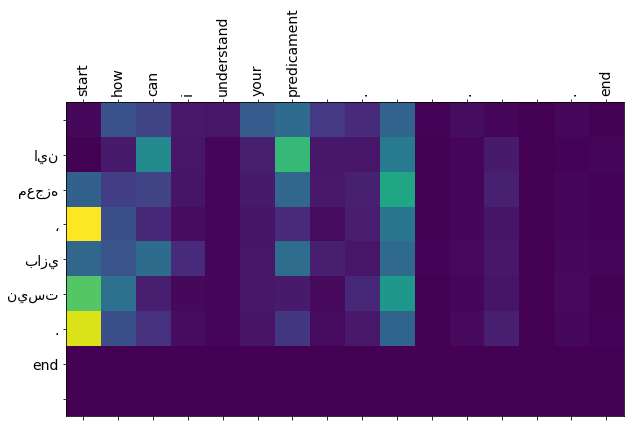

In [258]:
translate(sentence)